# 第1题

In [3]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

def generate_data(N=10000, d=100, seed=42):
    torch.manual_seed(seed)
    X = torch.randn(N, d)
    w_true = torch.randn(d)
    y = torch.sign(X @ w_true + 0.5 * torch.randn(N))
    return X, y

def logistic_loss(w, X, y):
    logits = X @ w
    return torch.mean(torch.log1p(torch.exp(-y * logits)))

In [4]:
def run_optimizer(name, optimizer_fn, X, y, lr=0.01, max_iter=1000):
    d = X.shape[1]
    w = torch.zeros(d, requires_grad=True)
    optimizer = optimizer_fn([w], lr=lr)
    loss_list, time_list = [], []
    start = time.time()
    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = logistic_loss(w, X, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        time_list.append(time.time() - start)
    return loss_list, time_list


In [5]:
from adan_pytorch import Adan

def compare_optimizers():
    X, y = generate_data()
    results = {}

    optimizers = {
        "SGD": lambda params, lr: torch.optim.SGD(params, lr=lr),
        "Momentum": lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9),
        "NAG": lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9, nesterov=True),
        "AdaGrad": lambda params, lr: torch.optim.Adagrad(params, lr=lr),
        "AdaDelta": lambda params, lr: torch.optim.Adadelta(params, lr=lr),
        "Adam": lambda params, lr: torch.optim.Adam(params, lr=lr),
        "Adan": lambda params, lr: Adan(params, lr=lr),
    }

    for name, opt_fn in optimizers.items():
        print(f"Running {name}...")
        loss, times = run_optimizer(name, opt_fn, X, y, lr=0.01)
        results[name] = (loss, times)

    # 绘图
    plt.figure(figsize=(10, 6))
    for name, (loss, times) in results.items():
        plt.plot(times, loss, label=name)
    plt.xlabel("Time (s)")
    plt.ylabel("Loss")
    plt.title("收敛速度对比")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running SGD...
Running Momentum...
Running NAG...
Running AdaGrad...
Running AdaDelta...
Running Adam...
Running Adan...


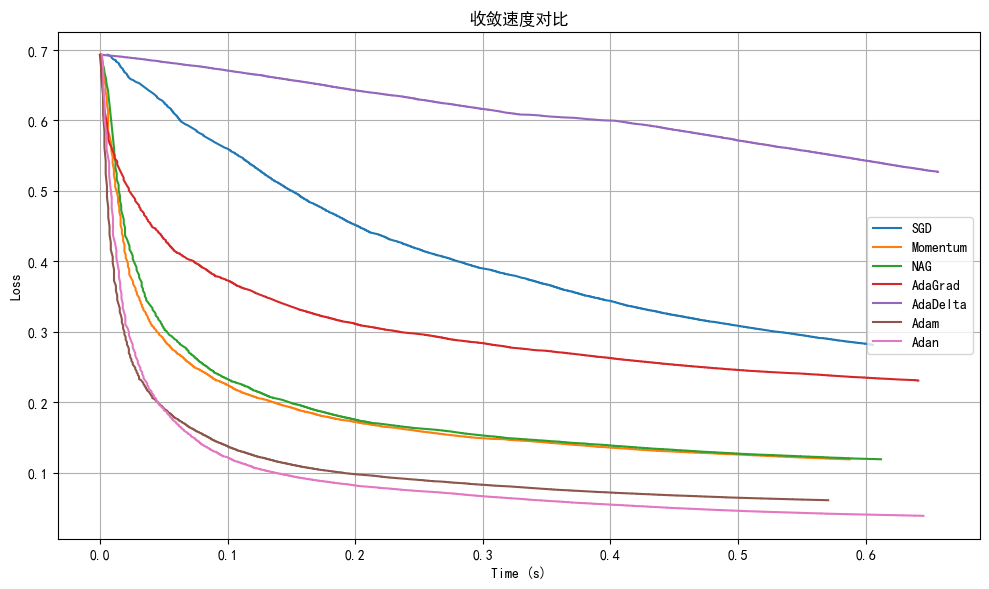

In [6]:
compare_optimizers()

# 第2题

In [7]:
def adam_optimizer(X, y, lr=0.01, max_iter=200):
    d = X.shape[1]
    w = torch.zeros(d, requires_grad=True)
    optimizer = torch.optim.Adam([w], lr=lr)
    loss_list, time_list = [], []
    start = time.time()
    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = logistic_loss(w, X, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        time_list.append(time.time() - start)
    return loss_list, time_list

# ------- RCD(1) 方法 --------
def rcd_optimizer(X, y, lr=0.01, max_iter=1000):
    N, d = X.shape
    w = torch.zeros(d)
    beta_hat = torch.ones(d) * 0.1  # 初始 β_i 估计
    loss_list, time_list = [], []
    start = time.time()
    for t in range(max_iter):
        i = torch.randint(0, d, (1,)).item()  # 随机选一个坐标
        logits = X @ w
        probs = torch.sigmoid(-y * logits)
        grad_i = torch.mean(probs * (-y) * X[:, i])  # 第 i 个分量的梯度
        beta_hat[i] = 0.9 * beta_hat[i] + 0.1 * grad_i**2  # 更新 β_i 估计
        w[i] -= lr / (torch.sqrt(beta_hat[i]) + 1e-8) * grad_i  # RCD update
        if t % 5 == 0:
            loss = logistic_loss(w, X, y)
            loss_list.append(loss.item())
            time_list.append(time.time() - start)
    return loss_list, time_list

In [8]:
# ------- 比较两种方法 --------
def compare_adam_rcd():
    X, y = generate_data(N = 1000, d = 10000)
    print("Running Adam...")
    adam_loss, adam_time = adam_optimizer(X, y)
    print("Running RCD(1)...")
    rcd_loss, rcd_time = rcd_optimizer(X, y)

    plt.figure(figsize=(10, 6))
    plt.plot(adam_time, adam_loss, label='Adam')
    plt.plot(rcd_time, rcd_loss, label='RCD(1)')
    plt.xlabel("Time (s)")
    plt.ylabel("Loss")
    plt.title("收敛速度对比")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Running Adam...
Running RCD(1)...


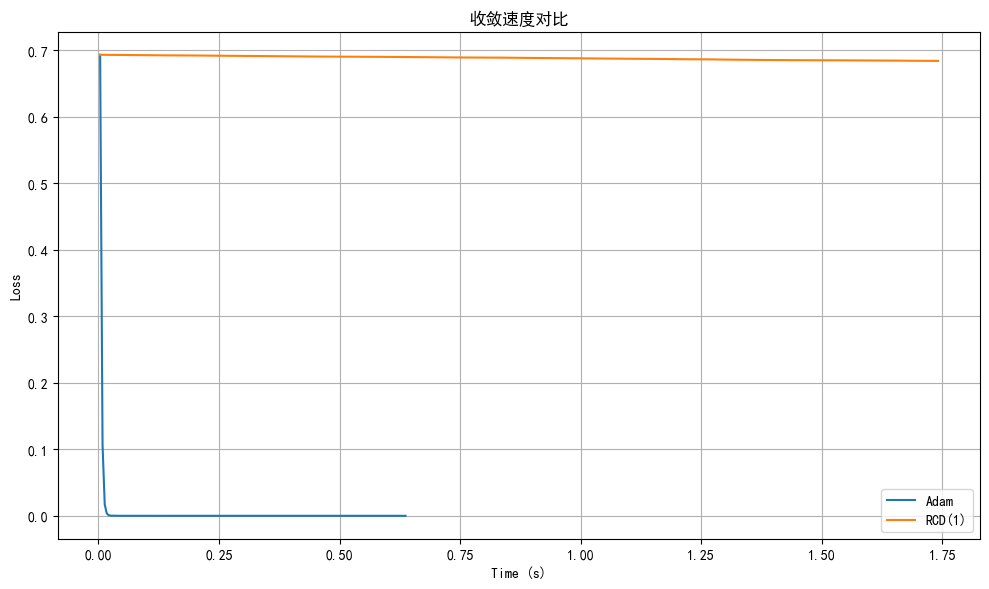

In [9]:
compare_adam_rcd()

# 第3题

In [40]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def stochastic_admm_logistic_regression(X, y, rho=0.01, max_iter=1000, eta_0=0.01):
    N, d = X.shape
    
    # 初始化变量
    w = np.zeros(d)
    z = np.ones(d) / d  # 初始化z满足 1^T z = 1
    u = np.zeros(d + 1)  # u ∈ R^(d+1)
    
    # 定义矩阵 A1, A2, b
    A1 = np.vstack([np.eye(d), np.zeros((1, d))])  # (d+1, d)
    A2 = np.vstack([-np.eye(d), np.ones((1, d))])  # (d+1, d)
    b = np.zeros(d + 1)
    b[-1] = 1

    residual = []
    losses = []
    
    for k in range(max_iter):
        # 动态调整步长 eta_k
        eta_k = eta_0 / np.sqrt(k + 1)
        
        # 随机选取样本 i_k
        i_k = np.random.randint(N)
        x_i = X[i_k]
        y_i = y[i_k]
        
        # 计算梯度 ∇f_{i_k}(w^k) = - y_i x_i σ(- y_i x_i^T w^k)
        pred = x_i.dot(w)
        grad_f = -y_i * x_i * sigmoid(-y_i * pred)
        
        # 更新 w^(k+1)
        # 目标是解二次问题： 
        # min_w grad_f^T (w - w^k) + (rho/2) ||A1 w + A2 z^k - b + u^k / rho||^2 + (1/(2 eta_k)) ||w - w^k||^2
        Q = (rho * (A1.T @ A1)) + (np.eye(d) / eta_k)
        q = - grad_f - rho * A1.T @ (A2 @ z - b + u / rho) + w / eta_k

        # 求解线性方程 Q w_new = q
        w = np.linalg.solve(Q, q)
        
        # 更新 z^(k+1)
        # 对z求最小化：
        # min_z  (rho/2) ||A1 w^{k+1} + A2 z - b + u^k / rho||^2
        # 展开：
        # min_z (rho/2) ||A2 z - c||^2, 其中 c = b - A1 w^{k+1} - u^k / rho
        
        c = b - A1.dot(w) - u / rho
        
        # 这是一个无约束的二次规划问题：
        # min_z ||A2 z - c||^2
        # 其解为 z = (A2^T A2)^{-1} A2^T c       
        A2T = A2.T
        M = A2T.dot(A2)  # (d,d)
        v = A2T.dot(c)
        z = np.linalg.solve(M, v)
        
        # 更新 u^(k+1)
        u = u + rho * (A1.dot(w) + A2.dot(z) - b)
        
        # 迭代日志（可选）
        
            # 计算当前目标函数值（用全样本）
        logits = X.dot(w)
        loss = np.mean(np.log(1 + np.exp(-y * logits)))
        constr_residual = np.linalg.norm(A1.dot(w) + A2.dot(z) - b)
        if (k + 1) % 100 == 0 or k == 0:
            print(f"迭代 {k+1}, 损失: {loss:.4f}, 约束残差: {constr_residual:.4e}")

        constr_residual = np.linalg.norm(A1.dot(w) + A2.dot(z) - b)
        residual.append(constr_residual)
        losses.append(loss)
    
    return w, z, residual, losses

In [44]:
X, y = generate_data(N=10000, d=100, seed = 42)
X = X.numpy()
y = y.numpy()
    
w_opt, z_opt, risedual, losses = stochastic_admm_logistic_regression(X, y, rho = 0.1, max_iter=10000, eta_0=0.1)

迭代 1, 损失: 0.7171, 约束残差: 1.7060e-01
迭代 100, 损失: 0.5576, 约束残差: 1.8519e-02
迭代 200, 损失: 0.4721, 约束残差: 1.2353e-02
迭代 300, 损失: 0.4365, 约束残差: 5.5990e-03
迭代 400, 损失: 0.4099, 约束残差: 7.3307e-03
迭代 500, 损失: 0.3926, 约束残差: 1.2173e-02
迭代 600, 损失: 0.3788, 约束残差: 3.0924e-02
迭代 700, 损失: 0.3652, 约束残差: 1.3970e-02
迭代 800, 损失: 0.3540, 约束残差: 1.9481e-02
迭代 900, 损失: 0.3449, 约束残差: 2.7128e-02
迭代 1000, 损失: 0.3375, 约束残差: 1.0315e-02
迭代 1100, 损失: 0.3314, 约束残差: 3.0523e-02
迭代 1200, 损失: 0.3251, 约束残差: 3.9760e-03
迭代 1300, 损失: 0.3196, 约束残差: 2.3371e-02
迭代 1400, 损失: 0.3146, 约束残差: 6.0411e-03
迭代 1500, 损失: 0.3106, 约束残差: 2.7903e-02
迭代 1600, 损失: 0.3064, 约束残差: 6.2994e-03
迭代 1700, 损失: 0.3026, 约束残差: 3.8035e-02
迭代 1800, 损失: 0.2990, 约束残差: 5.3642e-03
迭代 1900, 损失: 0.2961, 约束残差: 3.8962e-02
迭代 2000, 损失: 0.2922, 约束残差: 1.2723e-02
迭代 2100, 损失: 0.2885, 约束残差: 2.8837e-02
迭代 2200, 损失: 0.2862, 约束残差: 1.6842e-02
迭代 2300, 损失: 0.2839, 约束残差: 2.5061e-02
迭代 2400, 损失: 0.2817, 约束残差: 1.9902e-02
迭代 2500, 损失: 0.2793, 约束残差: 1.7713e-02
迭代 2600, 损失: 0.2772, 约束残

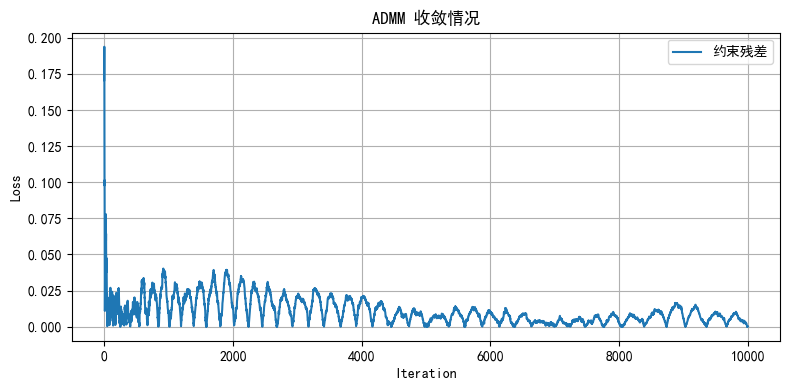

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(risedual, label='约束残差')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('ADMM 收敛情况')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

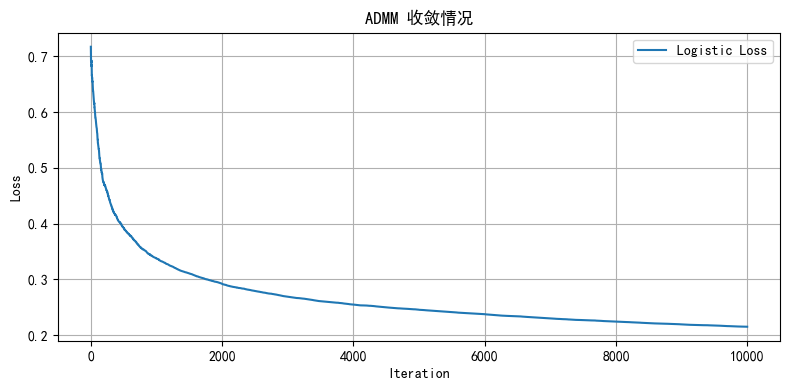

In [49]:
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Logistic Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('ADMM 收敛情况')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 